In [1]:
import numpy as np
import pandas as pd
import pandas_profiling as pp
import tensorflow as tf
from tensorflow import keras

from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

2021-09-01 02:39:40.790503: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-09-01 02:39:40.790541: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [4]:
raw_df = pd.read_csv('../../../test-builds/llvm/datasets/model-aug-29.csv')
raw_df.head()

,fullpath,modulepath,function,BasicBlockCount,BasicBlockWithSingleSuccessor,BasicBlockWithTwoSuccessors,BasicBlockWithMoreThanTwoSuccessors,BasicBlockWithSinglePredecessor,BasicBlockWithTwoPredecessors,BasicBlockWithMoreThanTwoPredecessors,...,CastInstCount,FloatingPointInstCount,IntegerInstCount,LoadInstCount,StoreInstCount,CallInstCount,PHIInstCount,AllocaInstCount,GEPInstCount,label
0,/mnt/disks/data/tarindu/test-builds/llvm/code-...,/mnt/disks/data/tarindu/test-builds/llvm/code-...,_GLOBAL__sub_I_APFixedPointTest.cpp,100,55,33,11,55,33,11,...,110,0,0,110,176,222,0,44,143,O2
1,/mnt/disks/data/tarindu/test-builds/llvm/code-...,/mnt/disks/data/tarindu/test-builds/llvm/code-...,_ZN10llvm_gtestlsERSoRKNS_14RawStreamProxyIA1...,7,3,3,0,4,1,1,...,5,0,1,4,8,7,1,1,12,FNF
2,/mnt/disks/data/tarindu/test-builds/llvm/code-...,/mnt/disks/data/tarindu/test-builds/llvm/code-...,_ZN10llvm_gtestlsERSoRKNS_14RawStreamProxyIN4...,3,1,1,0,1,1,0,...,5,0,0,4,7,9,0,2,11,O1-O2-O3-FNF
3,/mnt/disks/data/tarindu/test-builds/llvm/code-...,/mnt/disks/data/tarindu/test-builds/llvm/code-...,_ZN10llvm_gtestlsERSoRKNS_14RawStreamProxyIPKcEE,7,3,3,0,4,1,1,...,5,0,1,5,8,7,1,1,11,O1-O2-O3-FNF
4,/mnt/disks/data/tarindu/test-builds/llvm/code-...,/mnt/disks/data/tarindu/test-builds/llvm/code-...,_ZN12_GLOBAL__N_112CheckIntPartERKN4llvm19Fix...,148,65,74,0,95,38,14,...,86,0,48,94,53,147,4,33,92,O2


In [5]:
raw_df['label'].describe()

count            178012
unique               11
top        O1-O2-O3-FNF
freq              84434
Name: label, dtype: object

### Clean Dataset

In [6]:
cleaned_df = raw_df.copy()

# don't want the 'fullpath', 'modulepath', 'function' columns
cleaned_df = cleaned_df.drop(['fullpath', 'modulepath', 'function'], axis=1)

cleaned_df.rename(columns={' BasicBlockCount': 'BasicBlockCount'}, inplace=True)

def clean_labels(x):
    if x.strip() == 'O1':
        return 1 
    elif x.strip() == 'O2':
        return 2 
    elif x.strip() == 'O3':
        return 3
    else:
        return 0
    

cleaned_df['label'] = cleaned_df['label'].map(clean_labels)

cleaned_df.head()        

,BasicBlockCount,BasicBlockWithSingleSuccessor,BasicBlockWithTwoSuccessors,BasicBlockWithMoreThanTwoSuccessors,BasicBlockWithSinglePredecessor,BasicBlockWithTwoPredecessors,BasicBlockWithMoreThanTwoPredecessors,BigBasicBlock,MediumBasicBlock,SmallBasicBlock,...,CastInstCount,FloatingPointInstCount,IntegerInstCount,LoadInstCount,StoreInstCount,CallInstCount,PHIInstCount,AllocaInstCount,GEPInstCount,label
0,100,55,33,11,55,33,11,0,22,78,...,110,0,0,110,176,222,0,44,143,2
1,7,3,3,0,4,1,1,0,1,6,...,5,0,1,4,8,7,1,1,12,0
2,3,1,1,0,1,1,0,0,1,2,...,5,0,0,4,7,9,0,2,11,0
3,7,3,3,0,4,1,1,0,1,6,...,5,0,1,5,8,7,1,1,11,0
4,148,65,74,0,95,38,14,0,7,141,...,86,0,48,94,53,147,4,33,92,2


### Examine the class label imbalance

In [7]:
np.bincount(cleaned_df['label'])

array([95945,  9763, 47887, 24417])

In [8]:
cleaned_df['label'].value_counts()

0    95945
2    47887
3    24417
1     9763
Name: label, dtype: int64

In [9]:
o_none, o1, o2, o3 = np.bincount(cleaned_df['label'])
total = o_none + o1 + o2 + o3
print(f'O1: {o1/total}')
print(f'O2: {o2/total}')
print(f'O3: {o3/total}')
print(f'O0: {o_none/total}')

O1: 0.05484461721681684
O2: 0.2690099543850976
O3: 0.13716491023077096
O0: 0.5389805181673145


### Split the dataframe into train, validation, and test

In [10]:
train, test = train_test_split(cleaned_df, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)
print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

113927 train examples
28482 validation examples
35603 test examples


### Create an input pipeline using tf.data

In [11]:
# A utility method to create a tf.data dataset from a Pandas Dataframe
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
    dataframe = dataframe.copy()
    labels = dataframe.pop('label')
    labels = pd.get_dummies(labels)
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    ds = ds.prefetch(batch_size)
    return ds

In [12]:
batch_size = 5
train_ds = df_to_dataset(train, batch_size=batch_size)

In [13]:
train_ds

<PrefetchDataset shapes: ({BasicBlockCount: (None,), BasicBlockWithSingleSuccessor: (None,), BasicBlockWithTwoSuccessors: (None,), BasicBlockWithMoreThanTwoSuccessors: (None,), BasicBlockWithSinglePredecessor: (None,), BasicBlockWithTwoPredecessors: (None,), BasicBlockWithMoreThanTwoPredecessors: (None,), BigBasicBlock: (None,), MediumBasicBlock: (None,), SmallBasicBlock: (None,), BlocksReachedFromConditionalInstruction: (None,), Uses: (None,), DirectCallsToDefinedFunctions: (None,), MaxLoopDepth: (None,), TopLevelLoopCount: (None,), IntegerConstantOccurrences: (None,), FloatingConstantOccurrences: (None,), InstructionCount: (None,), CastInstCount: (None,), FloatingPointInstCount: (None,), IntegerInstCount: (None,), LoadInstCount: (None,), StoreInstCount: (None,), CallInstCount: (None,), PHIInstCount: (None,), AllocaInstCount: (None,), GEPInstCount: (None,)}, (None, 4)), types: ({BasicBlockCount: tf.int64, BasicBlockWithSingleSuccessor: tf.int64, BasicBlockWithTwoSuccessors: tf.int64, 

In [14]:
[(train_features, label_batch)] = train_ds.take(1)
print('Every feature:', list(train_features.keys()))
print('A batch of labels:', label_batch )

Every feature: ['BasicBlockCount', 'BasicBlockWithSingleSuccessor', 'BasicBlockWithTwoSuccessors', 'BasicBlockWithMoreThanTwoSuccessors', 'BasicBlockWithSinglePredecessor', 'BasicBlockWithTwoPredecessors', 'BasicBlockWithMoreThanTwoPredecessors', 'BigBasicBlock', 'MediumBasicBlock', 'SmallBasicBlock', 'BlocksReachedFromConditionalInstruction', 'Uses', 'DirectCallsToDefinedFunctions', 'MaxLoopDepth', 'TopLevelLoopCount', 'IntegerConstantOccurrences', 'FloatingConstantOccurrences', 'InstructionCount', 'CastInstCount', 'FloatingPointInstCount', 'IntegerInstCount', 'LoadInstCount', 'StoreInstCount', 'CallInstCount', 'PHIInstCount', 'AllocaInstCount', 'GEPInstCount']
A batch of labels: tf.Tensor(
[[1 0 0 0]
 [1 0 0 0]
 [0 0 1 0]
 [0 0 1 0]
 [0 0 0 1]], shape=(5, 4), dtype=uint8)


### preprocessing layers 

In [15]:
def get_normalization_layer(name, dataset):
  # Create a Normalization layer for our feature.
  normalizer = preprocessing.Normalization(axis=None)

  # Prepare a Dataset that only yields our feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the statistics of the data.
  normalizer.adapt(feature_ds)

  return normalizer

### Choose which columns to use

In [16]:
batch_size = 2048
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

In [17]:
numeric_features = ['BasicBlockCount', 'BasicBlockWithSingleSuccessor', 'BasicBlockWithTwoSuccessors', 
                    'BasicBlockWithMoreThanTwoSuccessors', 'BasicBlockWithSinglePredecessor', 
                    'BasicBlockWithTwoPredecessors', 'BasicBlockWithMoreThanTwoPredecessors', 
                    'BigBasicBlock', 'MediumBasicBlock', 'SmallBasicBlock', 
                    'BlocksReachedFromConditionalInstruction', 'Uses', 'DirectCallsToDefinedFunctions', 
                    'MaxLoopDepth', 'TopLevelLoopCount', 'IntegerConstantOccurrences', 
                    'FloatingConstantOccurrences', 'InstructionCount', 'CastInstCount', 
                    'FloatingPointInstCount', 'IntegerInstCount', 'LoadInstCount', 'StoreInstCount', 
                    'CallInstCount', 'PHIInstCount', 'AllocaInstCount', 'GEPInstCount']

In [18]:
all_inputs = []
encoded_features = []

# Numeric features.
for header in numeric_features:
  numeric_col = tf.keras.Input(shape=(1,), name=header)
  normalization_layer = get_normalization_layer(header, train_ds)
  encoded_numeric_col = normalization_layer(numeric_col)
  all_inputs.append(numeric_col)
  encoded_features.append(encoded_numeric_col)

2021-09-01 02:41:23.859575: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


### Create, compile, and train the model

In [18]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [19]:
all_features = tf.keras.layers.concatenate(encoded_features)
x = tf.keras.layers.Dense(32, activation="relu")(all_features)
x = tf.keras.layers.Dropout(0.5)(x)
# softmax and categorical cross entropy for multiclass
output = tf.keras.layers.Dense(4, activation = 'softmax')(x)
model = tf.keras.Model(all_inputs, output)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=METRICS)

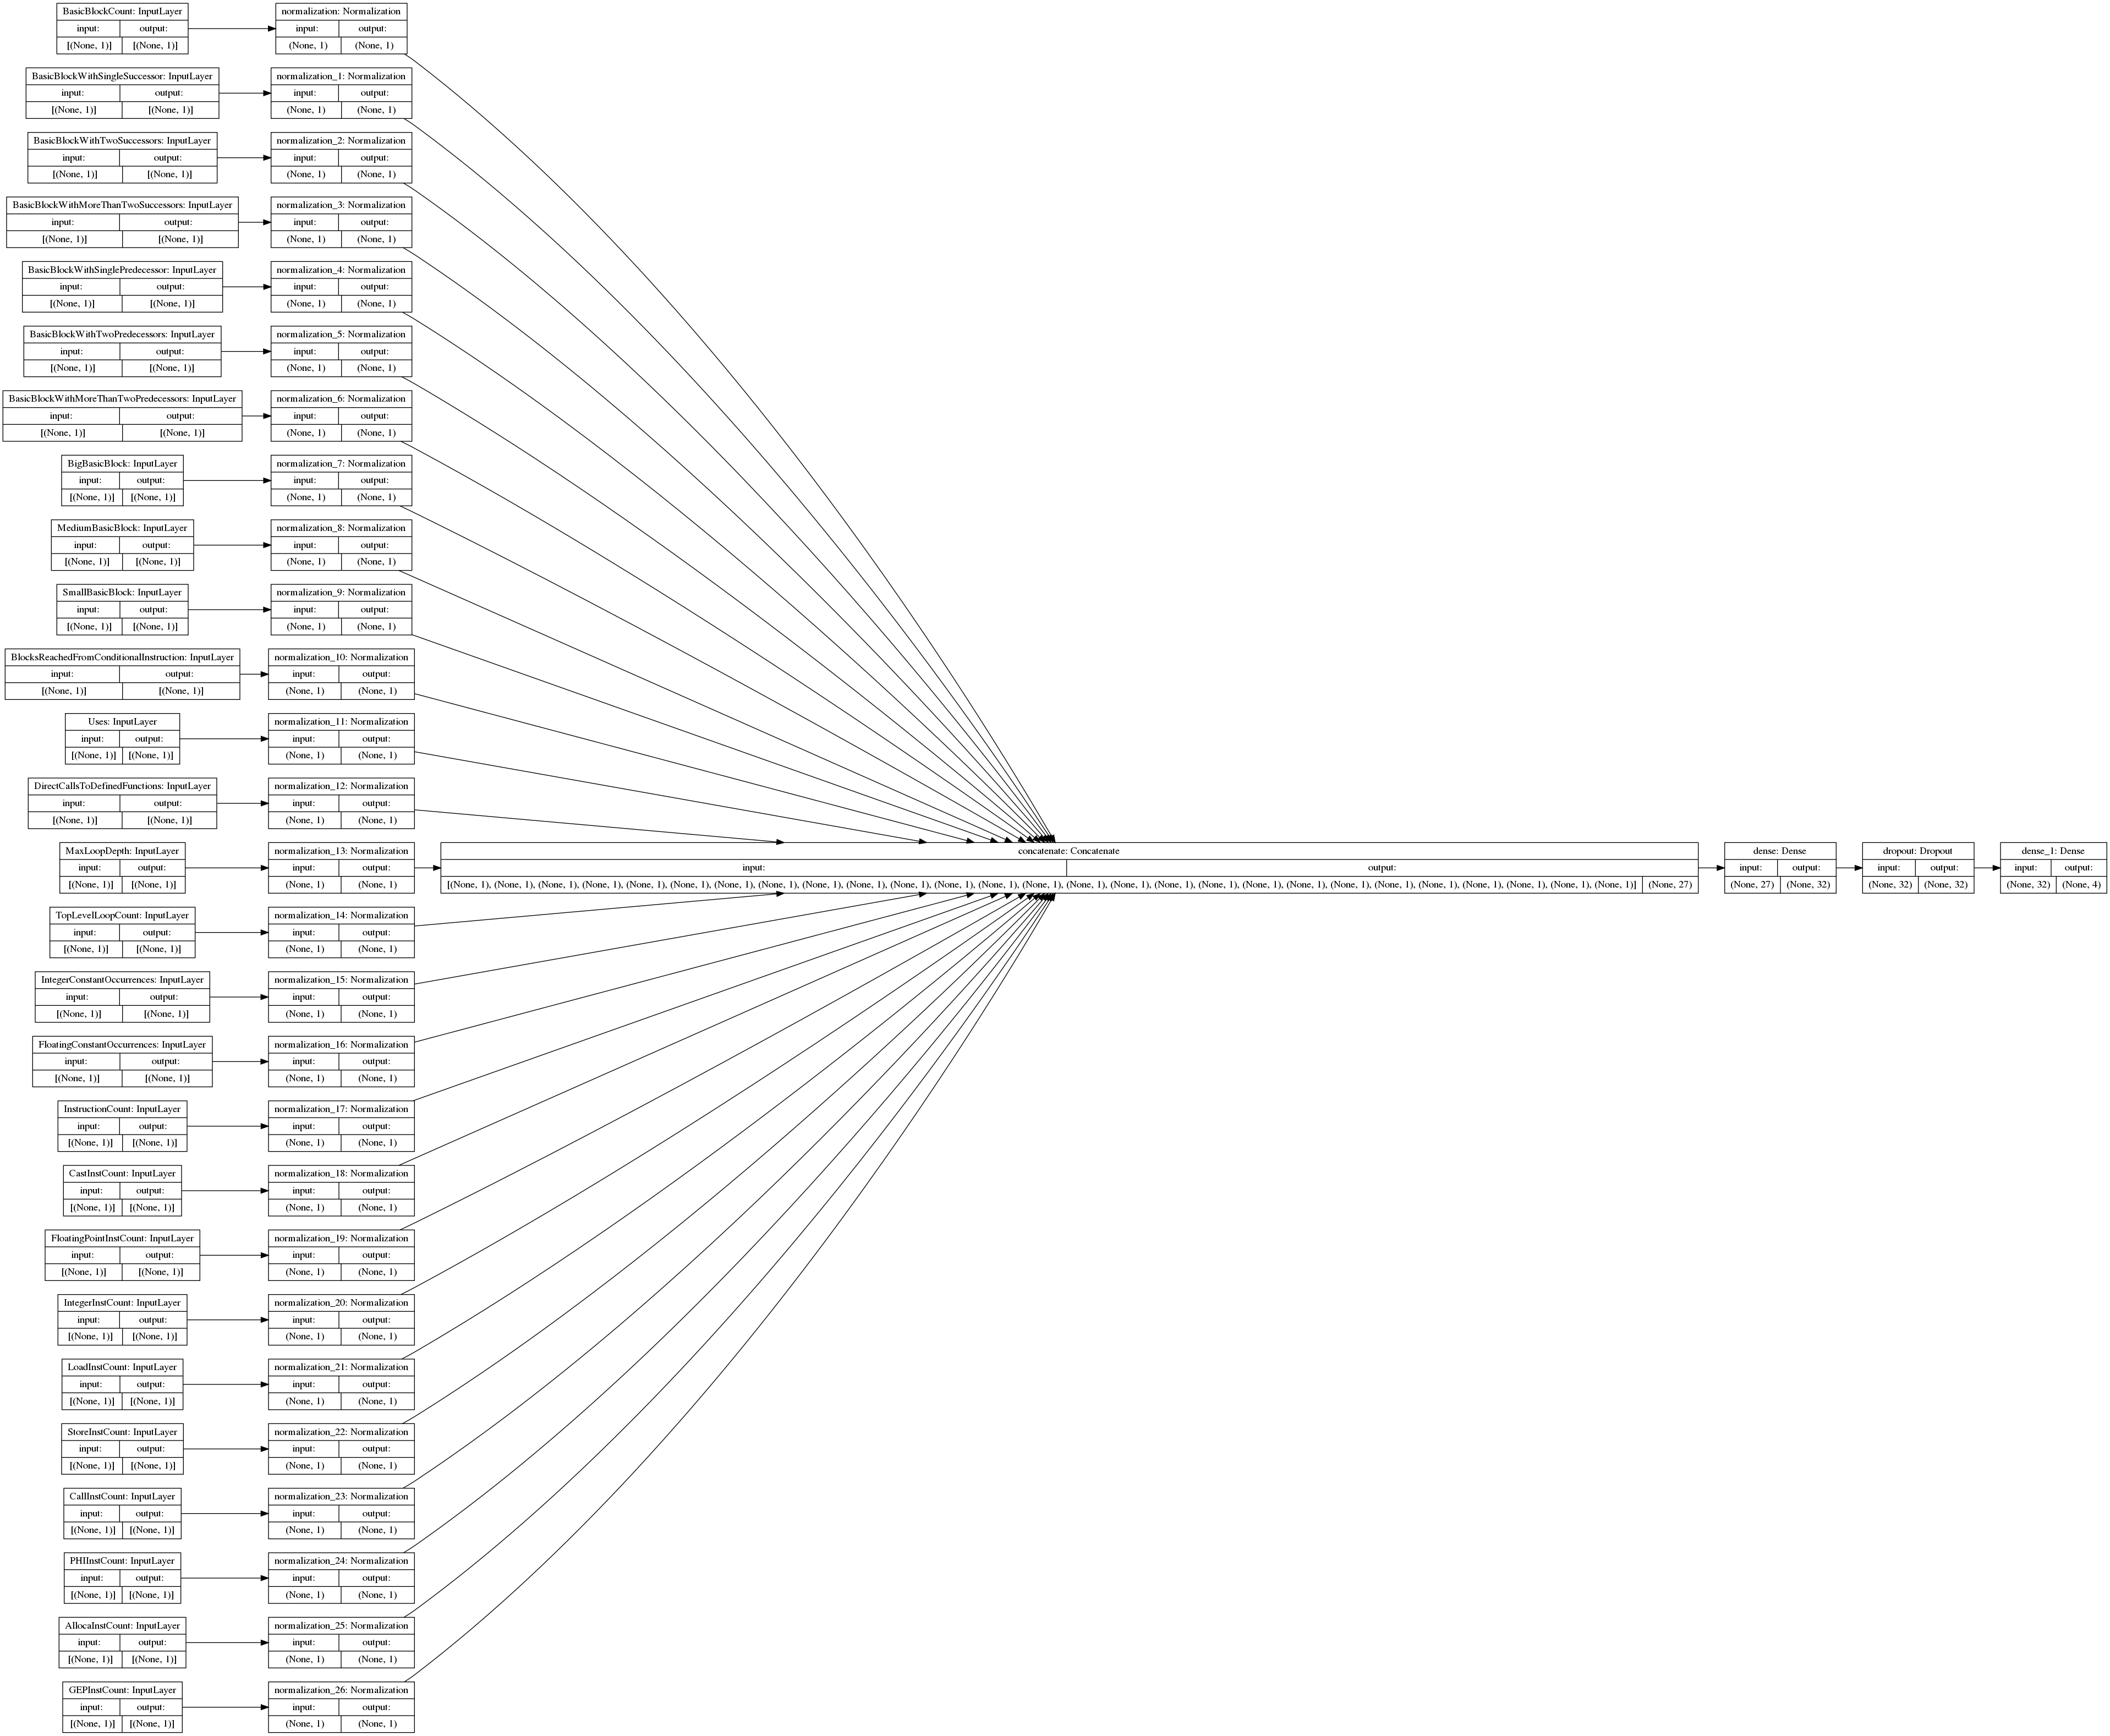

In [20]:
# rankdir='LR' is used to make the graph horizontal.
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

### Train the mode

In [21]:
model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
56/56 [==============================] - 7s 56ms/step - loss: 1.3093 - tp: 4674.0000 - fp: 4468.0000 - tn: 337313.0000 - fn: 109253.0000 - accuracy: 0.7505 - precision: 0.5113 - recall: 0.0410 - auc: 0.6971 - prc: 0.4187 - val_loss: 1.1351 - val_tp: 980.0000 - val_fp: 622.0000 - val_tn: 84824.0000 - val_fn: 27502.0000 - val_accuracy: 0.7531 - val_precision: 0.6117 - val_recall: 0.0344 - val_auc: 0.8194 - val_prc: 0.5952
Epoch 2/10
56/56 [==============================] - 4s 36ms/step - loss: 1.1021 - tp: 32810.0000 - fp: 16653.0000 - tn: 325128.0000 - fn: 81117.0000 - accuracy: 0.7855 - precision: 0.6633 - recall: 0.2880 - auc: 0.7969 - prc: 0.5596 - val_loss: 1.0068 - val_tp: 13358.0000 - val_fp: 6452.0000 - val_tn: 78994.0000 - val_fn: 15124.0000 - val_accuracy: 0.8106 - val_precision: 0.6743 - val_recall: 0.4690 - val_auc: 0.8325 - val_prc: 0.6327
Epoch 3/10
56/56 [==============================] - 3s 35ms/step - loss: 1.0465 - tp: 46024.0000 - fp: 23870.0000 - tn: 317911

In [22]:
model.evaluate(test_ds)

18/18 [==============================] - 1s 28ms/step - loss: 0.9437 - tp: 16565.0000 - fp: 7564.0000 - tn: 99245.0000 - fn: 19038.0000 - accuracy: 0.8132 - precision: 0.6865 - recall: 0.4653 - auc: 0.8467 - prc: 0.6576


[0.9437313675880432,
 16565.0,
 7564.0,
 99245.0,
 19038.0,
 0.8132039308547974,
 0.6865183115005493,
 0.4652697741985321,
 0.8466700315475464,
 0.6576480269432068]

In [ ]:
model.save('acc_81_aug_30')

In [2]:
model = tf.keras.models.load_model('acc_81_aug_30')

2021-09-01 02:40:23.503895: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-09-01 02:40:23.503952: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-09-01 02:40:23.503972: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (cpu-only): /proc/driver/nvidia/version does not exist
2021-09-01 02:40:23.504273: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [19]:
model.evaluate(test_ds)

18/18 [==============================] - 2s 22ms/step - loss: 0.9431 - tp: 16482.0000 - fp: 7373.0000 - tn: 99436.0000 - fn: 19121.0000 - accuracy: 0.8140 - precision: 0.6909 - recall: 0.4629 - auc: 0.8465 - prc: 0.6592


[0.9430713057518005,
 16482.0,
 7373.0,
 99436.0,
 19121.0,
 0.8139622807502747,
 0.690924346446991,
 0.462938517332077,
 0.8464750051498413,
 0.6592008471488953]

In [41]:
predictions = model.predict(test_ds)

In [42]:
predictions

array([[0.27480125, 0.06861479, 0.42268375, 0.23390023],
       [0.33745578, 0.01280847, 0.32985684, 0.31987897],
       [0.7383969 , 0.03562761, 0.18837892, 0.03759657],
       ...,
       [0.69812566, 0.08354474, 0.18664476, 0.03168483],
       [0.6540164 , 0.0370032 , 0.24720758, 0.06177275],
       [0.7056943 , 0.08972712, 0.17306602, 0.03151247]], dtype=float32)

In [43]:
predictions.shape

(35603, 4)

In [55]:
y_test = np.concatenate([y for x, y in test_ds], axis=0)

In [62]:
y_pred = np.argmax(predictions, axis=-1)

y_true=np.argmax(y_test, axis=-1)

In [66]:
y_true

array([2, 2, 0, ..., 1, 0, 2])

In [71]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [67]:
print('Confusion Matrix\n')
print(confusion)

Confusion Matrix

[[17187     0  1307   740]
 [ 1810     0   164    11]
 [ 6195     0  2710   570]
 [ 1717     0  1659  1533]]


In [74]:
(17187+2710+1533)/35603

0.6019155689127321

In [73]:
cm.sum()

35603

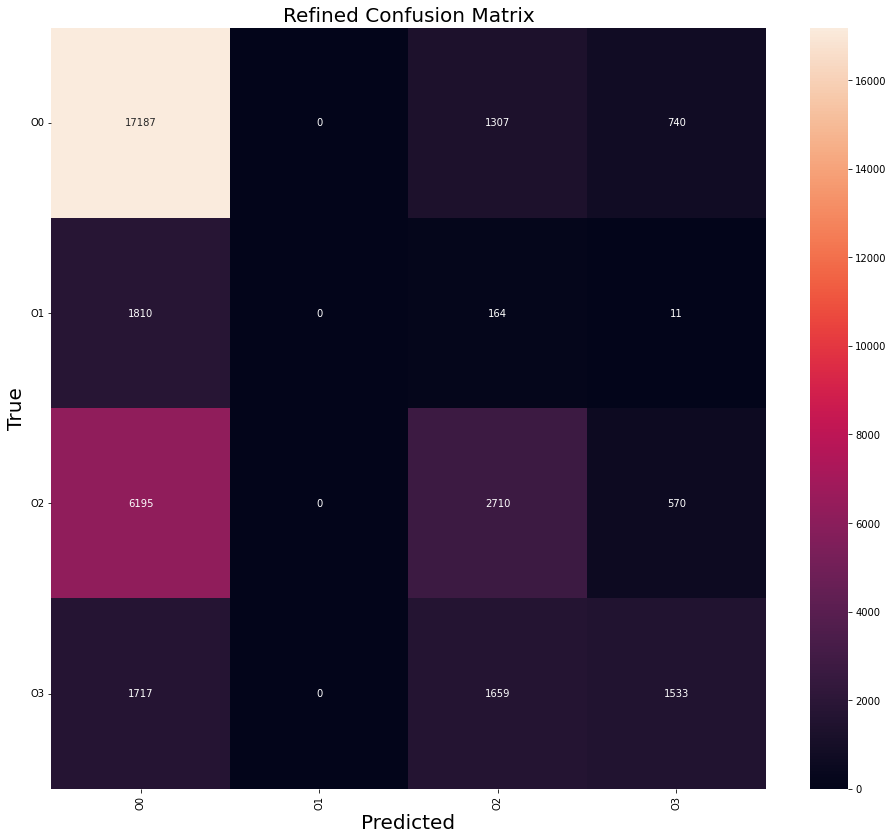

In [72]:
cm = confusion_matrix(y_true, y_pred)

## Get Class Labels
labels = ['O0', 'O1', 'O2', 'O3']
class_names = labels

# Plot confusion matrix in a beautiful manner
fig = plt.figure(figsize=(16, 14))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g'); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted', fontsize=20)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(class_names, fontsize = 10)
ax.xaxis.tick_bottom()

ax.set_ylabel('True', fontsize=20)
ax.yaxis.set_ticklabels(class_names, fontsize = 10)
plt.yticks(rotation=0)

plt.title('Refined Confusion Matrix', fontsize=20)

plt.savefig('ConMat24.png')
plt.show()

In [106]:
sample = {'BasicBlockCount': 100,
 'BasicBlockWithSingleSuccessor': 55,
 'BasicBlockWithTwoSuccessors': 33,
 'BasicBlockWithMoreThanTwoSuccessors': 11,
 'BasicBlockWithSinglePredecessor': 55,
 'BasicBlockWithTwoPredecessors': 33,
 'BasicBlockWithMoreThanTwoPredecessors': 11,
 'BigBasicBlock': 0,
 'MediumBasicBlock': 22,
 'SmallBasicBlock': 78,
 'BlocksReachedFromConditionalInstruction': 99,
 'Uses': 1,
 'DirectCallsToDefinedFunctions': 22,
 'MaxLoopDepth': 0,
 'TopLevelLoopCount': 0,
 'IntegerConstantOccurrences': 660,
 'FloatingConstantOccurrences': 0,
 'InstructionCount': 938,
 'CastInstCount': 110,
 'FloatingPointInstCount': 0,
 'IntegerInstCount': 0,
 'LoadInstCount': 110,
 'StoreInstCount': 176,
 'CallInstCount': 222,
 'PHIInstCount': 0,
 'AllocaInstCount': 44,
 'GEPInstCount': 143 }

input_dict = {name: tf.convert_to_tensor([value]) for name, value in sample.items()}
predictions = model.predict(input_dict)

In [107]:
tf.nn.sigmoid(predictions)

<tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[0.539082  , 0.50054395, 0.6301228 , 0.57650274]], dtype=float32)>

In [108]:
predictions

array([[0.15664741, 0.00217575, 0.5327437 , 0.30843318]], dtype=float32)